# Image pixel-level saliency using VGG-19 Conv-net

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. The `pretrained_vgg_models` contains some useful functions for building and acquiring VGG models.

In [2]:
import os, sys, time
import numpy as np
from matplotlib import pyplot as plt
import theano
import lasagne
import skimage.transform, skimage.util
import pretrained_vgg_models
import scipy

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer, Pool2DLayer, Conv2DLayer, NINLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX


/Users/Geoff/packages/Theano/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Load an image to process

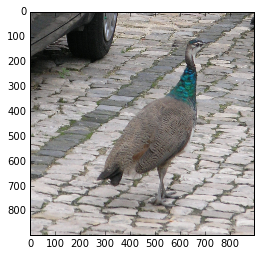

In [3]:
IMAGE_PATH = os.path.join('images', 'P1013781.JPG')
# Extract a 896 x 896 block surrounding the peacock
img = plt.imread(IMAGE_PATH)[1800:2696,652:1548]
plt.imshow(img)
plt.show()

## Load the model

To save some time, we are going to use the `VGG19Model` class from `pretrained_vgg_models` to build the network and load its parameters:

In [4]:
vgg19_model = pretrained_vgg_models.VGG19Model.load()

Prepare the image, scaling to 224x224:

In [5]:
raw_img, img_for_vgg = vgg19_model.prepare_image(img, image_size=224)

## Creating deep dreams

To create a deep dream image, we exaggerate the $L^2$ norm of the features of the image from a chosen (target) convolutional layer of the network.

We do this by using gradient ascent to iteratively modify the input image to maximise the $L^2$ norm of the target features.

In [30]:
# Name the layer whose features we are going to maximise
TARGET_LAYER_NAME = 'pool5'
# For convolutional layers, the tensor type is `tensor4`
Y_TENSOR_TYPE = theano.tensor.tensor4

# Shared value for the input image; this is so that Theano can update it
X = theano.shared(floatX(img_for_vgg), name='x')
# Variable for the mask; this allows us to select specific channels or regions of the image to work on if we wish
mask_var = Y_TENSOR_TYPE('m')
# Varaible for the sum of the mask; this can be computed once at the beginning therefore potentially
# saving some computations at run-time.
mask_sum_var = theano.tensor.scalar('mask_sum')
# Dreaming rate variable; the rate of gradient ascent, like the learning rate for SGD
dream_rate_var = theano.tensor.scalar('dream_rate')

# Ask Lasagne for a Theano expression that represents the features at the target layer
feat_sym = lasagne.layers.get_output(vgg19_model.network[TARGET_LAYER_NAME], X, deterministic=True)

# Compute a Theano expression representing the L^2 norm of the target features, with the mask
# applied. Note that technically we are computing the mean of squares rather than sum of squares;
# using the sum of squares can result in huge values in `feats_norm` which can quickly tend
# towards NaN by going out of bounds
feats_norm = (feat_sym**2 * mask_var).sum() / mask_sum_var

# Get the gradient of `feats_norm` with respect to X
feats_norm_grad = theano.grad(feats_norm, wrt=X)

# Function to compute the features at the target layer, forward only
feat_fn = theano.function([], feat_sym)

# Deep dream iteration function
# Updates: X = X + feats_norm_grad * dream_rate_var 
updates = {X: X + feats_norm_grad * dream_rate_var}
# Theano function that applies the udpates
dream_iter_fn = theano.function([mask_var, mask_sum_var, dream_rate_var], feat_sym, updates=updates)

Compute a saliency image as a tensor:

In [35]:
# Initialise X to the image contents
X.set_value(floatX(img_for_vgg))
# Compute the target features for the initial image
y = feat_fn()

# Mask: all 1
m = floatX(np.ones_like(y))

# Compute mask sum (add 1.0e-6 just to prevent divide by 0, should the value of `m` be changed)
m_sum = floatX(np.abs(m).sum() + 1.0e-6)

# Dream rates found for various layers by trial and error
DREAM_RATES = {
    'pool1': 15.0,
    'pool2': 1.5,
    'pool3': 0.1,
    'pool4': 0.5,
    'pool5': 40.0,
}
dream_rate = DREAM_RATES.get(TARGET_LAYER_NAME, 0.5)

# Run for 75 epochs
t1 = time.time()
for i in xrange(75):
    if i % 25 == 0:
        # Every 25 epochs, compute the target layer features and show stats
        dt = time.time() - t1
        y_prime = feat_fn()
        y_prime_m = y_prime[m.astype(bool)]
        print('{}: at time {:.2f}s; y_prime: min={}, max={}, y_prime_m: min={}, max={}'.format(
                i, dt, y_prime.min(), y_prime.max(), y_prime_m.min(), y_prime_m.max()))

    # Call the iteration function, updating the variables.
    dream_iter_fn(m, m_sum, floatX(dream_rate))

# Print final stats
dt = time.time() - t1
y_prime = feat_fn()
y_prime_m = y_prime[m.astype(bool)]
print('FINAL: at time {:.2f}s; y_prime: min={}, max={}, y_prime_m: min={}, max={}'.format(
        dt, y_prime.min(), y_prime.max(), y_prime_m.min(), y_prime_m.max()))


0: at time 0.00s; y_prime: min=-1.30832195282e-05, max=1598.4588623, y_prime_m: min=-1.30832195282e-05, max=1598.4588623
25: at time 6.66s; y_prime: min=-2.98768281937e-05, max=2382.68212891, y_prime_m: min=-2.98768281937e-05, max=2382.68212891
50: at time 12.97s; y_prime: min=-2.98768281937e-05, max=3585.93066406, y_prime_m: min=-2.98768281937e-05, max=3585.93066406
FINAL: at time 19.22s; y_prime: min=-5.54919242859e-05, max=5440.56933594, y_prime_m: min=-5.54919242859e-05, max=5440.56933594


Plot the original image along-side the hallicination:

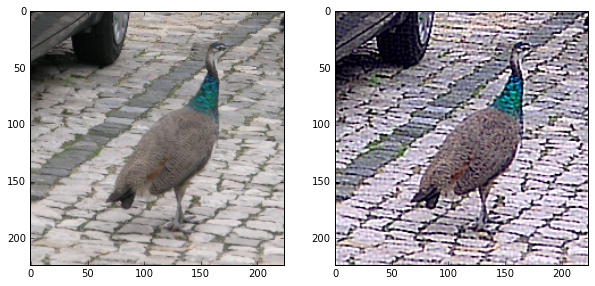

In [36]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw_img)
plt.subplot(1,2,2)
plt.imshow(vgg19_model.inv_prepare_image(X.get_value()))
plt.show()
